#### Paquetes necesarios

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

#### Carga y visualización de las imágenes

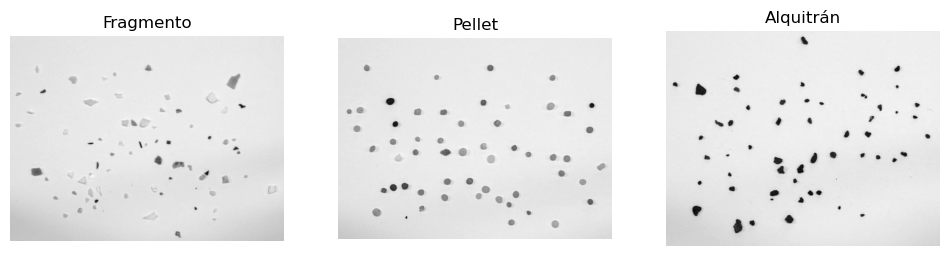

In [53]:
# Cargar las tres imágenes: fragmentos, pellets y alquitrán
frag_img = cv2.imread('Images/fragment-03-olympus-10-01-2020.JPG')
pel_img = cv2.imread('Images/pellet-03-olympus-10-01-2020.JPG')
tar_img = cv2.imread('Images/tar-03-olympus-10-01-2020.JPG')

# Convertir las imágenes a escala de grises
frag_gris = cv2.cvtColor(frag_img, cv2.COLOR_BGR2GRAY)
pel_gris = cv2.cvtColor(pel_img, cv2.COLOR_BGR2GRAY)
tar_gris = cv2.cvtColor(tar_img, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro de suavizado
frag_gris = cv2.GaussianBlur(frag_gris, (25, 25), 0)

# Mostrar las imágenes
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Fragmento')
plt.axis("off")
plt.imshow(frag_gris,cmap='gray') 

plt.subplot(1, 3, 2)
plt.title('Pellet')
plt.axis("off")
plt.imshow(pel_gris,cmap='gray') 

plt.subplot(1, 3, 3)
plt.title('Alquitrán')
plt.axis("off")
plt.imshow(tar_gris,cmap='gray') 

plt.show()


#### Umbralizado de las imágenes

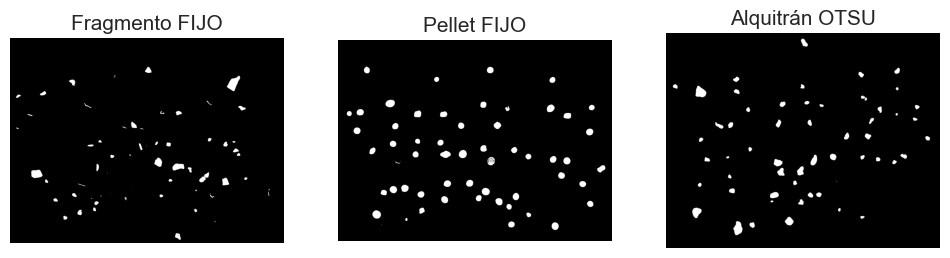

In [183]:
# Umbralizado normal
_,frag_umbral = cv2.threshold(frag_gris,110,255,cv2.THRESH_BINARY_INV)
_,pel_umbral = cv2.threshold(pel_gris,100,255,cv2.THRESH_BINARY_INV)

# Umbralizado con método de Otsu
_,tar_umbral = cv2.threshold(tar_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Mostrar las imágenes umbralizadas
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Fragmento FIJO')
plt.axis("off")
plt.imshow(frag_umbral,cmap='gray') 

plt.subplot(1, 3, 2)
plt.title('Pellet FIJO')
plt.axis("off")
plt.imshow(pel_umbral,cmap='gray') 

plt.subplot(1, 3, 3)
plt.title('Alquitrán OTSU')
plt.axis("off")
plt.imshow(tar_umbral,cmap='gray') 

plt.show()

#### Clasificación y matriz de confusión

Eje mayor: 92.75057983398438
Eje menor: 62.33456802368164

Área: 4137.0
Perímetro: 268.7939374446869
Relación de Aspecto: 0.8823529411764706
Compacidad: 17.464389849412193
Relación Área/Contenedor: 0.6489411764705882
Relación Ejes Elipse: 0.6720666127937442
Excentricidad: 0.7404906940454711
Relación Distancias: 0.0
Eje mayor: 13.776569366455078
Eje menor: 10.862156867980957

Área: 96.0
Perímetro: 37.79898917675018
Relación de Aspecto: 0.9230769230769231
Compacidad: 14.88295398733414
Relación Área/Contenedor: 0.6153846153846154
Relación Ejes Elipse: 0.7884515062530372
Excentricidad: 0.615096921051729
Relación Distancias: 0.0
Eje mayor: 57.72942352294922
Eje menor: 46.29235076904297

Área: 1923.0
Perímetro: 173.19595801830292
Relación de Aspecto: 1.06
Compacidad: 15.598980693644174
Relación Área/Contenedor: 0.7256603773584905
Relación Ejes Elipse: 0.8018848612032361
Excentricidad: 0.5974785932341566
Relación Distancias: 0.0
Eje mayor: 70.39179229736328
Eje menor: 55.21632766723633

Área:

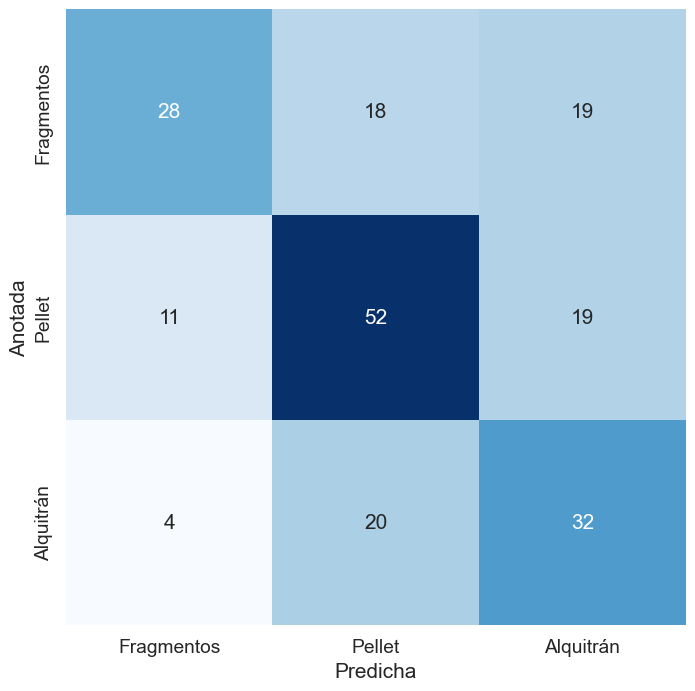

In [195]:
# Función para contar elementos de cada clase en una imagen
def contar_elementos(imagen):

    # Encontrar los contornos en la imagen
    contornos, _ = cv2.findContours(imagen, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Contar elementos de cada clase (fragmentos, pellets, alquitrán)
    fragmentos = 0  
    pellet = 0 
    alquitran = 0

    for contorno in contornos:
        # Área del contorno
        area = cv2.contourArea(contorno)

        # Perímetro del contorno
        perimetro = cv2.arcLength(contorno, True)

        # Contenedor alineado con ejes de la imagen (Bounding Box)
        x, y, w, h = cv2.boundingRect(contorno)

        # Mínimo contenedor ajustado para el contorno (Rotated Rect)
        rect = cv2.minAreaRect(contorno)
        (rect_x, rect_y), (rect_ancho, rect_alto), rect_angulo = rect

        # Mínimo círculo que lo contiene
        (cx, cy), radio = cv2.minEnclosingCircle(contorno)

        # Calcula la relación de aspecto
        relacion_aspecto = w / h

        # Calcula la compacidad
        compacidad = (perimetro ** 2) / area if area > 0 else 0

        # Calcula la relación entre el área del contorno y el área del contenedor
        relacion_area_contenedor = area / (w * h)

        # Calcula la relación entre los ejes de la elipse ajustada
        # eje_mayor, eje_menor = rect_ancho, rect_alto
        # relacion_ejes_elipse = eje_menor / eje_mayor if eje_mayor > 0 else 0

        # Elpise que contiene el contorno
        eje_mayor, eje_menor, relacion_ejes_elipse, excentricidad = 0, 0, 0, 0
        if contorno.shape[0] > 5:
            elipse = cv2.fitEllipse(contorno)
            centroide = elipse[0]
            eje_mayor = elipse[1][1]
            eje_menor = elipse[1][0]
            relacion_ejes_elipse = eje_menor / eje_mayor 
            excentricidad = np.sqrt(1 - (relacion_ejes_elipse ** 2))

        print("Eje mayor:", eje_mayor)
        print("Eje menor:", eje_menor)

        # Calcula el centroide
        M = cv2.moments(contorno)
        cx = int(M['m10'] / M['m00']) if M['m00'] != 0 else 0
        cy = int(M['m01'] / M['m00']) if M['m00'] != 0 else 0

        # Calcula la relación entre las distancias menor y mayor al contorno
        distancia_menor = np.min(np.linalg.norm(contorno - (cx, cy), axis=1))
        distancia_mayor = np.max(np.linalg.norm(contorno - (cx, cy), axis=1))
        relacion_distancias = distancia_menor / distancia_mayor

        if compacidad < 16 and np.isclose(relacion_aspecto, 1.0, rtol=0.8):
            pellet += 1
        elif relacion_area_contenedor < 0.6 and relacion_ejes_elipse < 0.8:
            fragmentos += 1
        else:
            alquitran += 1
        # Aquí puedes imprimir o utilizar estas características según tus necesidades
        print("\nÁrea:", area)
        print("Perímetro:", perimetro)
        print("Relación de Aspecto:", relacion_aspecto)
        print("Compacidad:", compacidad)
        print("Relación Área/Contenedor:", relacion_area_contenedor)
        print("Relación Ejes Elipse:", relacion_ejes_elipse)
        print("Excentricidad:", excentricidad)
        print("Relación Distancias:", relacion_distancias)
        

    return [fragmentos, pellet, alquitran]

# Contar elementos de cada clase en cada imagen
conteo_fragmentos = contar_elementos(frag_umbral)
conteo_pellet = contar_elementos(pel_umbral)
conteo_alquitran = contar_elementos(tar_umbral)

# Crear una matriz de confusión global
matriz_confusion = np.array([conteo_fragmentos, conteo_pellet, conteo_alquitran])

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.25)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels=['Fragmentos', 'Pellet', 'Alquitrán'], yticklabels=['Fragmentos', 'Pellet', 'Alquitrán'])
plt.xlabel("Predicha")
plt.ylabel("Anotada")
plt.show()